In [1]:
#Imports
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')
# Install required libraries
!pip install ema-pytorch==0.2.1;pandas==1.5.0;scikit-learn==1.1.2;scipy==1.8.1;seaborn==0.12.2;tqdm==4.64.1;dm-control==1.0.12;dm-env==1.6;dm-tree==0.1.8;mujoco==2.3.4;gluonts==0.12.6;pyyaml==6.0
import os
import torch
import numpy as np
import sys

# Add the project directory to the system path
sys.path.insert(0,'/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS')
# Import custom modules
from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

from Utils.metric_utils import display_scores
from Utils.discriminative_metric import discriminative_score_metrics
from Utils.predictive_metric import predictive_score_metrics

import itertools
import yaml
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from Utils.cross_correlation import CrossCorrelLoss
# Install gluonts (again, just to be sure)
!pip install gluonts

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Import additional libraries for data processing and model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one

Mounted at /content/drive
/bin/bash: line 1: scikit-learn==1.1.2: command not found
/bin/bash: line 1: dm-control==1.0.12: command not found
/bin/bash: line 1: dm-env==1.6: command not found
/bin/bash: line 1: dm-tree==0.1.8: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.5 MB/s eta 0:00:00


In [38]:
dataset1 = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/Relativ/Dollar_Neg_1_30.npy')
dataset2 = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/Relativ/GDP_Neg_1_30.npy')
dataset3 = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/Relativ/Interest_Pos_1_30.npy')

In [39]:
# Get the last value of the historical data
last_historical_value = historical_data[-1, :]

# Function to transform relative changes back to original scale
def transform_relative_to_original(dataset, last_value):
    """Transforms relative changes back to the original scale."""
    transformed_dataset = np.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        transformed_dataset[i, 0, :] = last_value * (1 + dataset[i, 0, :])
        for j in range(1, dataset.shape[1]):
            transformed_dataset[i, j, :] = transformed_dataset[i, j-1, :] * (1 + dataset[i, j, :])
    return transformed_dataset

# Transform the datasets
dataset1 = transform_relative_to_original(dataset1, last_historical_value)
dataset2 = transform_relative_to_original(dataset2, last_historical_value)
dataset3 = transform_relative_to_original(dataset3, last_historical_value)

In [41]:
def average_correlation_matrix_sequence_wise(dataset):
    """Calculates the average correlation matrix sequence-wise for a dataset."""
    num_sequences, seq_length, num_variables = dataset.shape
    sum_corr_matrix = np.zeros((num_variables, num_variables))

    for i in range(num_sequences):
        sequence = dataset[i]
        # Calculate correlation matrix for the current sequence
        corr_matrix = np.corrcoef(sequence, rowvar=False)
        sum_corr_matrix += corr_matrix

    # Calculate the average correlation matrix
    average_corr_matrix = sum_corr_matrix / num_sequences
    return average_corr_matrix

# Calculate the average correlation matrix for each dataset
avg_corr_matrix1 = average_correlation_matrix_sequence_wise(dataset1[:,6:,:])
avg_corr_matrix2 = average_correlation_matrix_sequence_wise(dataset2[:,6:,:])
avg_corr_matrix3 = average_correlation_matrix_sequence_wise(dataset3[:,6:,:])

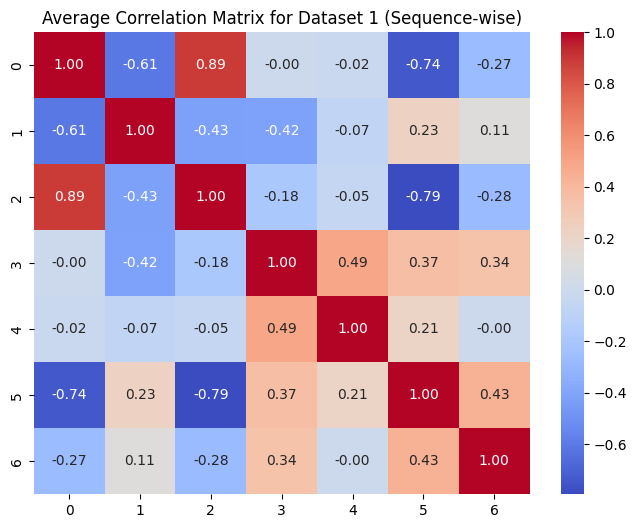

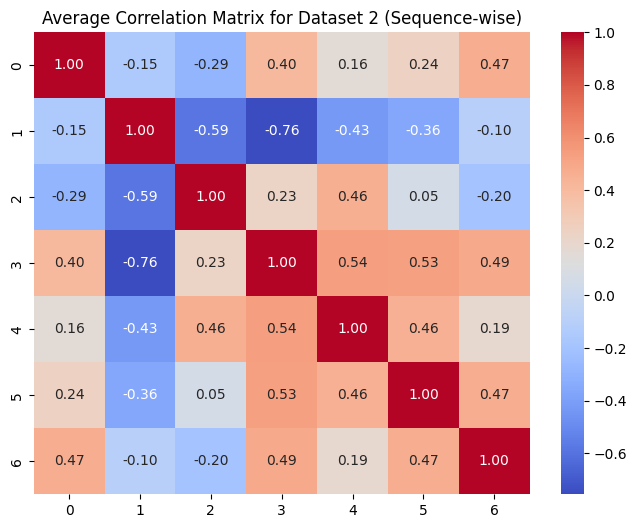

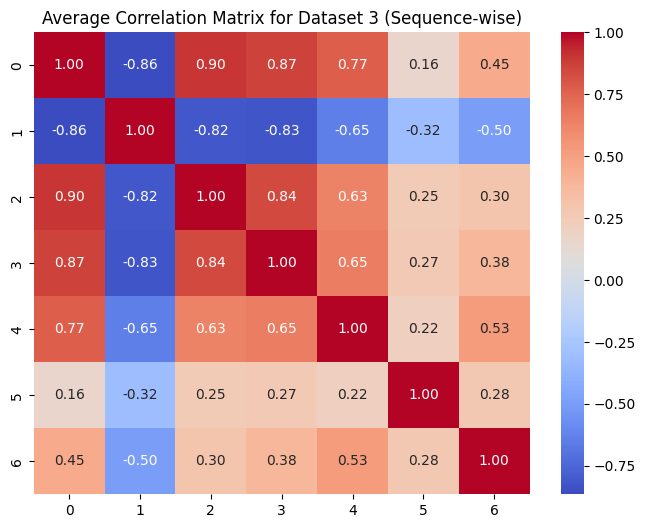

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the average correlation matrix for dataset 1
plt.figure(figsize=(8, 6))
sns.heatmap(avg_corr_matrix1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix for Dataset 1 (Sequence-wise)')
plt.show()

# Visualize the average correlation matrix for dataset 2
plt.figure(figsize=(8, 6))
sns.heatmap(avg_corr_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix for Dataset 2 (Sequence-wise)')
plt.show()

# Visualize the average correlation matrix for dataset 3
plt.figure(figsize=(8, 6))
sns.heatmap(avg_corr_matrix3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix for Dataset 3 (Sequence-wise)')
plt.show()

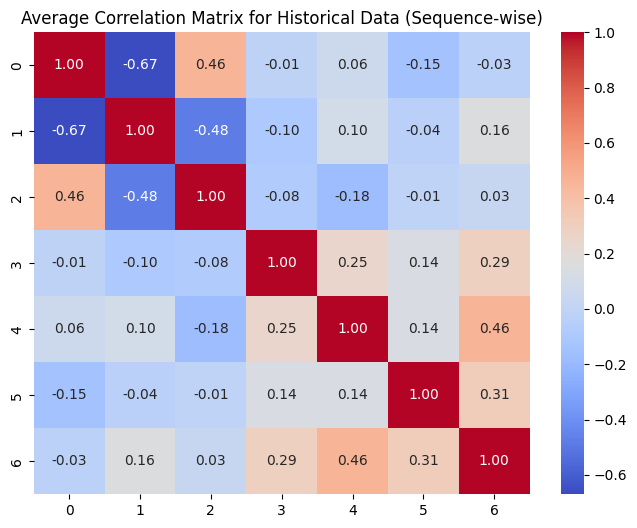

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the historical data
historical_data_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro_augemented.csv'
historical_df = pd.read_csv(historical_data_path)


historical_data = historical_df.iloc[:].values

def sequence_data(data, seq_length):
    num_samples, num_variables = data.shape
    num_sequences = num_samples - seq_length + 1
    sequenced_data = np.zeros((num_sequences, seq_length, num_variables))
    for i in range(num_sequences):
        sequenced_data[i] = data[i:i + seq_length, :]
    return sequenced_data

seq_length = 24 # Example sequence length
sequenced_historical_data = sequence_data(historical_data, seq_length)

# Calculate the average correlation matrix for the historical data (sequence-wise)
avg_corr_matrix_historical = average_correlation_matrix_sequence_wise(sequenced_historical_data)

# Visualize the average correlation matrix for the historical data
plt.figure(figsize=(8, 6))
sns.heatmap(avg_corr_matrix_historical, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix for Historical Data (Sequence-wise)')
plt.show()

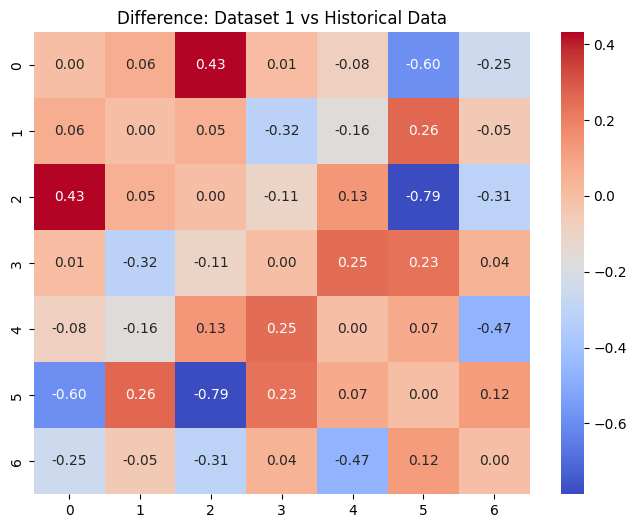

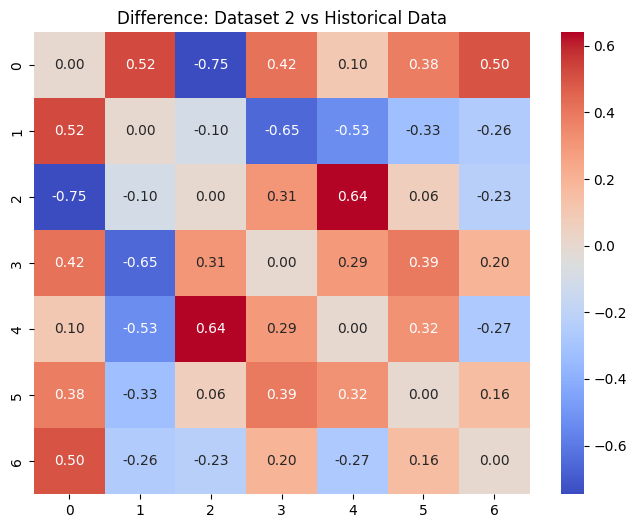

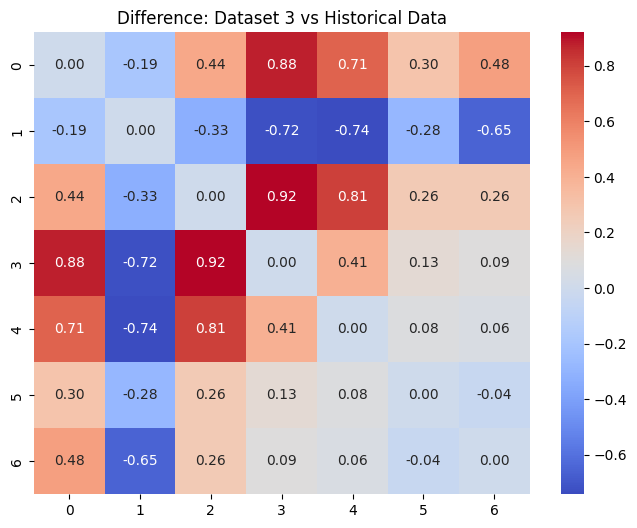

In [44]:
# Calculate the difference matrices
diff_matrix1 = avg_corr_matrix1 - avg_corr_matrix_historical
diff_matrix2 = avg_corr_matrix2 - avg_corr_matrix_historical
diff_matrix3 = avg_corr_matrix3 - avg_corr_matrix_historical

# Visualize the difference matrices
plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Difference: Dataset 1 vs Historical Data')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Difference: Dataset 2 vs Historical Data')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Difference: Dataset 3 vs Historical Data')
plt.show()

In [45]:
def get_average_sequence_statistics(dataset, dataset_name):
    """Calculates average statistics across all sequences in a dataset."""
    num_sequences, seq_length, num_variables = dataset.shape

    print(f"--- Average Statistics for {dataset_name} ---")

    # Calculate statistics across all sequences and timesteps
    mean_across_sequences = np.mean(dataset, axis=(0, 1))
    std_across_sequences = np.std(dataset, axis=(0, 1))
    min_across_sequences = np.min(dataset, axis=(0, 1))
    max_across_sequences = np.max(dataset, axis=(0, 1))


    print("  Average Mean:", mean_across_sequences)
    print("  Average Standard Deviation:", std_across_sequences)
    print("  Average Minimum:", min_across_sequences)
    print("  Average Maximum:", max_across_sequences)
    print("-" * 20)


get_average_sequence_statistics(dataset1, "Dataset 1")
get_average_sequence_statistics(dataset2, "Dataset 2")
get_average_sequence_statistics(dataset3, "Dataset 3")
get_average_sequence_statistics(sequenced_historical_data, "Historical Data")

--- Average Statistics for Dataset 1 ---
  Average Mean: [9.13366841e+05 3.98862856e+00 1.35068114e+02 3.71425896e+00
 9.40147442e-01 8.26406055e-01 1.24372801e+00]
  Average Standard Deviation: [1.18977343e+04 1.96941999e-01 1.84421083e+00 2.00541473e-01
 2.46616753e-02 4.37742583e-02 7.03849867e-02]
  Average Minimum: [9.00270477e+05 3.10041499e+00 1.31596083e+02 2.55344426e+00
 7.97098068e-01 6.87856094e-01 1.00708251e+00]
  Average Maximum: [9.67969529e+05 4.46380373e+00 1.39091135e+02 4.22874679e+00
 9.65008054e-01 9.11630815e-01 1.48310469e+00]
--------------------
--- Average Statistics for Dataset 2 ---
  Average Mean: [8.94902475e+05 3.98751168e+00 1.35236096e+02 3.75869951e+00
 9.44069928e-01 8.63815752e-01 1.21460189e+00]
  Average Standard Deviation: [1.35165908e+04 1.85227749e-01 1.86116871e+00 1.96129212e-01
 1.54581781e-02 1.24843080e-02 5.77331819e-02]
  Average Minimum: [8.62727439e+05 3.18672541e+00 1.31596083e+02 3.19891755e+00
 7.90674695e-01 8.30873211e-01 1.095834